### ***Step 5 LLM Augmentation***

#### ***Data preparation and dimensionality reduction***

It is planned to filter the existing dataset for 10-20 genes as an llm suggests. In the presented case, 17 genes were suggested and accordingly used to filter the dataset. 

In [4]:
import pandas as pd
from pathlib import Path

ER_GENES = [
    "ESR1", "PGR", "GATA3", "FOXA1", "TFF1", "GREB1",
    "CCND1", "NRIP1", "KRT18", "AR",
    "BCL2", "SCUBE2", "NAT1", "MLPH",
    "SLC39A6", "MAPT", "BAG1"
]

def save_filtered_gene_csv(
    df_gex: pd.DataFrame,
    genes: list[str],
    out_dir: Path,
    base_name: str = "mammacarcinoma_gex",
    id_col: str = "patient_id",
    suffix: str = "_llmaltered",
):
    """
    Filtert df_gex auf patient_id + gewünschte Gene (Spalten)
    und speichert die Datei als CSV im out_dir.
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    # Welche Gene sind wirklich im DF?
    present_genes = [g for g in genes if g in df_gex.columns]
    missing_genes = [g for g in genes if g not in df_gex.columns]

    if id_col not in df_gex.columns:
        raise ValueError(f"ID-Spalte '{id_col}' wurde nicht gefunden. Vorhanden: {list(df_gex.columns)[:10]} ...")

    if not present_genes:
        raise ValueError("Keines der gewünschten Gene wurde als Spalte gefunden.")

    cols = [id_col] + present_genes
    df_out = df_gex.loc[:, cols].copy()

    out_path = out_dir / f"{base_name}{suffix}.csv"
    df_out.to_csv(out_path, index=False)

    if missing_genes:
        print("Fehlende Gene:", ", ".join(missing_genes))


In [5]:
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results" 

df_gex = pd.read_csv(DATA_DIR / "mammacarcinoma_gex.csv")

save_filtered_gene_csv(
    df_gex=df_gex,
    genes=ER_GENES,
    out_dir=RESULTS_DIR,
    base_name="mammacarcinoma_gex"
)


Fehlende Gene: FOXA1, GREB1, SCUBE2, MLPH, SLC39A6


The code above filters for the assumed relevant genes

"bitte schreibe mir eine kleine pythin funktion, anhand der ich eine csv datein filter kann, die auf den zeilen Patienten hat aber in den Spalten einzelne Gene - ich möchte also ein neues .csv erstellen, das nur die 17 Gene enthält und als .csv_llmaltered gespeichert wird."

"ich habe wieder ein neues notebook geöffnet, hier sind die csv from pathlib import Path PROJECT_ROOT = Path.cwd().parent DATA_DIR = PROJECT_ROOT / "data" df_gex = pd.read_csv(DATA_DIR / "mammacarcinoma_gex.csv") df_pat = pd.read_csv(DATA_DIR / "mammacarcinoma_pat.csv") gex hat die gene im root / "results speichern""

12 Genes of the list were includet, resulting in an reduced list as expected but within the 10 - 20 range of required genes. 

In [6]:
import numpy as np

PROJECT_ROOT = Path.cwd().parent
RESULTS_DIR = PROJECT_ROOT / "results"

llm_path = RESULTS_DIR / "mammacarcinoma_gex_llmaltered.csv"
df_llm = pd.read_csv(llm_path)

id_col = "patient_id"
feature_cols = [c for c in df_llm.columns if c != id_col]

X_llm = df_llm[feature_cols].to_numpy()

print("Loaded:", llm_path)
print("Shape df_llm:", df_llm.shape)
print("Shape X_llm:", X_llm.shape)
print("First feature cols:", feature_cols[:10])

PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"

df_pat = pd.read_csv(DATA_DIR / "mammacarcinoma_pat.csv")

print(df_pat.shape)
print(df_pat.columns)

Loaded: C:\PAML\PAML Project\results\mammacarcinoma_gex_llmaltered.csv
Shape df_llm: (327, 13)
Shape X_llm: (327, 12)
First feature cols: ['ESR1', 'PGR', 'GATA3', 'TFF1', 'CCND1', 'NRIP1', 'KRT18', 'AR', 'BCL2', 'NAT1']
(327, 7)
Index(['patient_id', 'node', 'grade', 'size', 'age', 'er', 'relapse'], dtype='object')


In [7]:


PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"

df_pat = pd.read_csv(DATA_DIR / "mammacarcinoma_pat.csv")

print(df_pat.shape)
print(df_pat.columns)


(327, 7)
Index(['patient_id', 'node', 'grade', 'size', 'age', 'er', 'relapse'], dtype='object')


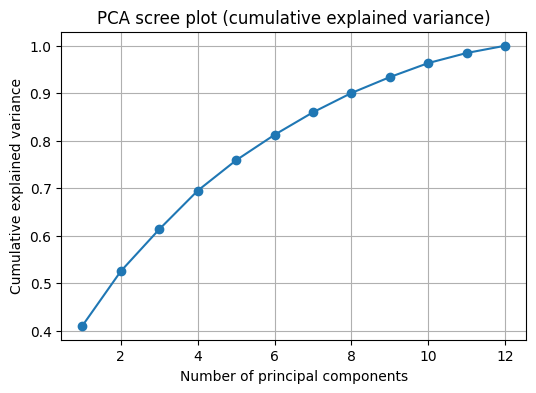

2 PCs -> 0.525 cumulative explained variance
3 PCs -> 0.614 cumulative explained variance
4 PCs -> 0.695 cumulative explained variance
5 PCs -> 0.759 cumulative explained variance
6 PCs -> 0.813 cumulative explained variance
7 PCs -> 0.860 cumulative explained variance
8 PCs -> 0.900 cumulative explained variance
9 PCs -> 0.934 cumulative explained variance
10 PCs -> 0.964 cumulative explained variance


In [8]:
#scree plot
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pre_pca = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=42))
])

X_llm_pre = pre_pca.fit_transform(X_llm)
pca = pre_pca.named_steps["pca"]

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(6, 4))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o"
)
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA scree plot (cumulative explained variance)")
plt.grid(True)
plt.show()

for k in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    if k <= len(cumulative_variance):
        print(f"{k} PCs -> {cumulative_variance[k-1]:.3f} cumulative explained variance")


Variance wise it seems reasonable to go for 5 PCs again, additionally fostering comparability with the task with the base-dataset!

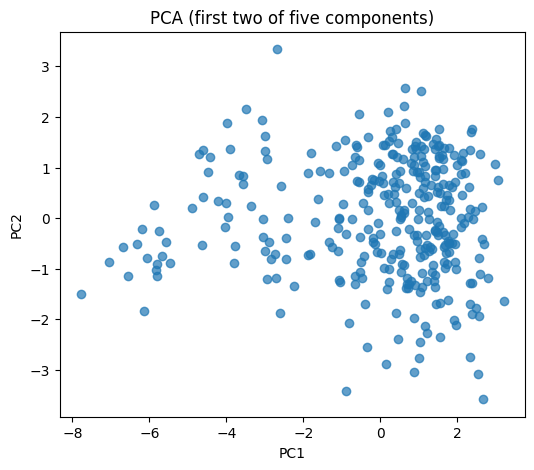

In [9]:
#PCA one color
from sklearn.decomposition import PCA

pre_pca_5 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5, random_state=42))
])

X_pca_5 = pre_pca_5.fit_transform(X_llm)

plt.figure(figsize=(6, 5))
plt.scatter(
    X_pca_5[:, 0],
    X_pca_5[:, 1],
    alpha=0.7
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (first two of five components)")
plt.show()


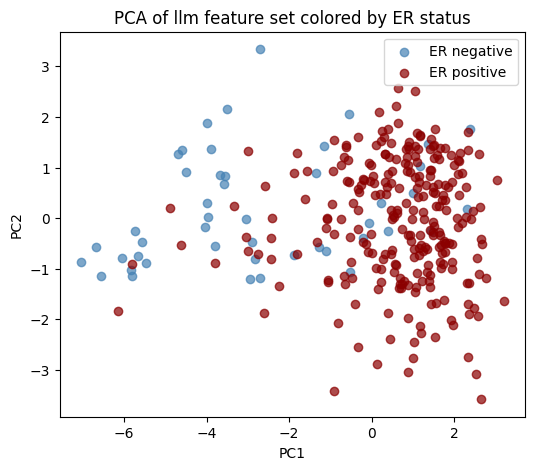

In [10]:
#PCA two colors, ER
df_plot_llm = df_llm.merge(df_pat[["patient_id", "er"]], on="patient_id", how="inner")

feature_cols = [c for c in df_plot_llm.columns if c not in ["patient_id", "er"]]
X_llm_plot = df_plot_llm[feature_cols].to_numpy()

X_pca_5 = pre_pca_5.fit_transform(X_llm_plot)

er_status = df_plot_llm["er"].to_numpy()

plt.figure(figsize=(6, 5))

plt.scatter(
    X_pca_5[er_status == 0, 0],
    X_pca_5[er_status == 0, 1],
    color="steelblue",
    alpha=0.7,
    label="ER negative"
)

plt.scatter(
    X_pca_5[er_status == 1, 0],
    X_pca_5[er_status == 1, 1],
    color="darkred",
    alpha=0.7,
    label="ER positive"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of llm feature set colored by ER status")
plt.legend()
plt.savefig(
    "PCA llm.jpeg",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


#### ***Classification methods and Evaluation PCA***

In [11]:
y = df_plot_llm["er"].to_numpy()

print("X shape:", X_llm_plot.shape)
print("y shape:", y.shape)
print("Class balance:", pd.Series(y).value_counts(normalize=True))


X shape: (327, 12)
y shape: (327,)
Class balance: 1.0    0.850649
0.0    0.149351
Name: proportion, dtype: float64


In [12]:
import numpy as np
import pandas as pd

y_raw = df_plot_llm["er"]

mask = y_raw.notna()
df_plot_llm_clean = df_plot_llm.loc[mask].copy()

feature_cols = [c for c in df_plot_llm_clean.columns if c not in ["patient_id", "er"]]
X_llm_plot = df_plot_llm_clean[feature_cols].to_numpy()

y = df_plot_llm_clean["er"].astype(int).to_numpy()

print("After dropping NaNs in y:")
print("X:", X_llm_plot.shape, "y:", y.shape)
print("Class balance:", pd.Series(y).value_counts(dropna=False))


After dropping NaNs in y:
X: (308, 12) y: (308,)
Class balance: 1    262
0     46
Name: count, dtype: int64


In [13]:
n_total = df_plot_llm.shape[0]
n_used = df_plot_llm_clean.shape[0]

print(f"Excluded due to missing ER status: {n_total - n_used} / {n_total}")


Excluded due to missing ER status: 19 / 327


In [14]:
#model pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

RANDOM_STATE = 42
N_COMPONENTS = 5

pre_pca_llm = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=N_COMPONENTS, random_state=RANDOM_STATE))
])

models_llm_pca = {
    "LogReg": Pipeline([
        ("pre", pre_pca_llm),
        ("model", LogisticRegression(
            max_iter=5000,
            class_weight="balanced",
            random_state=RANDOM_STATE
        ))
    ]),
    "RF": Pipeline([
        ("pre", pre_pca_llm),
        ("model", RandomForestClassifier(
            n_estimators=500,
            class_weight="balanced_subsample",
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    "kNN": Pipeline([
        ("pre", pre_pca_llm),
        ("model", KNeighborsClassifier(
            n_neighbors=11,
            weights="distance"
        ))
    ])
}


In [15]:
#calculate metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score, average_precision_score
import numpy as np
import pandas as pd

def cv_evaluate_models(models, X, y, target_name="er", n_splits=5, random_state=42):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    rows = []
    for model_name, estimator in models.items():
        fold_metrics = {"roc_auc": [], "balanced_acc": [], "f1": [], "avg_precision": []}

        for train_idx, test_idx in cv.split(X, y):
            X_tr, X_te = X[train_idx], X[test_idx]
            y_tr, y_te = y[train_idx], y[test_idx]

            estimator.fit(X_tr, y_tr)

            # Probabilities for AUC / Avg Precision
            if hasattr(estimator, "predict_proba"):
                y_prob = estimator.predict_proba(X_te)[:, 1]
            elif hasattr(estimator, "decision_function"):
                y_prob = estimator.decision_function(X_te)
            else:
                # fallback (not ideal, but avoids crash)
                y_prob = estimator.predict(X_te)

            y_pred = estimator.predict(X_te)

            fold_metrics["roc_auc"].append(roc_auc_score(y_te, y_prob))
            fold_metrics["avg_precision"].append(average_precision_score(y_te, y_prob))
            fold_metrics["balanced_acc"].append(balanced_accuracy_score(y_te, y_pred))
            fold_metrics["f1"].append(f1_score(y_te, y_pred))

        rows.append({
            "target": target_name,
            "model": model_name,
            "roc_auc": float(np.mean(fold_metrics["roc_auc"])),
            "balanced_acc": float(np.mean(fold_metrics["balanced_acc"])),
            "f1": float(np.mean(fold_metrics["f1"])),
            "avg_precision": float(np.mean(fold_metrics["avg_precision"])),

            # stability (optional but useful)
            "roc_auc_std": float(np.std(fold_metrics["roc_auc"])),
            "balanced_acc_std": float(np.std(fold_metrics["balanced_acc"])),
            "f1_std": float(np.std(fold_metrics["f1"])),
            "avg_precision_std": float(np.std(fold_metrics["avg_precision"])),
        })

    return pd.DataFrame(rows).sort_values(["target", "model"]).reset_index(drop=True)


In [16]:
df_metrics_llm = cv_evaluate_models(
    models=models_llm_pca,
    X=X_llm_plot,
    y=y,
    target_name="er",
    n_splits=5,
    random_state=RANDOM_STATE
)

df_metrics_llm


,target,model,roc_auc,balanced_acc,f1,avg_precision,roc_auc_std,balanced_acc_std,f1_std,avg_precision_std
0,er,LogReg,0.895493,0.820610,0.905366,0.978778,0.039080,0.029277,0.010816,0.008499
1,er,RF,0.868913,0.715237,0.942871,0.965305,0.074899,0.045406,0.013584,0.027980
2,er,kNN,0.884686,0.724461,0.942559,0.972939,0.055286,0.053180,0.012841,0.019446


In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    balanced_accuracy_score,
    f1_score,
    brier_score_loss
)

target_name = "er"

X_train, X_test, y_train, y_test = train_test_split(
    X_llm_plot,
    y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

rows = []

for model_name, pipe in models_llm_pca.items():
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    # Scores / probabilities
    if hasattr(pipe, "predict_proba"):
        y_score = pipe.predict_proba(X_test)[:, 1]
    elif hasattr(pipe, "decision_function"):
        y_score = pipe.decision_function(X_test)
    else:
        raise ValueError(f"{model_name}: no predict_proba or decision_function available.")

    rows.append({
        "target": target_name,
        "model": model_name,
        "roc_auc": roc_auc_score(y_test, y_score),
        "avg_precision": average_precision_score(y_test, y_score),
        "balanced_acc": balanced_accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "brier": brier_score_loss(y_test, y_score),
        "N_test": int(len(y_test)),
        "pos_rate_test": float(np.mean(y_test))
    })

df_llm_holdout = (
    pd.DataFrame(rows)
    .sort_values("roc_auc", ascending=False)
    .reset_index(drop=True)
)

df_llm_holdout.round(4)


,target,model,roc_auc,avg_precision,balanced_acc,f1,brier,N_test,pos_rate_test
0,er,kNN,0.8973,0.9799,0.7778,0.9636,0.0663,62,0.8548
1,er,LogReg,0.8931,0.9800,0.7956,0.9333,0.1111,62,0.8548
2,er,RF,0.8648,0.9737,0.7778,0.9636,0.0725,62,0.8548


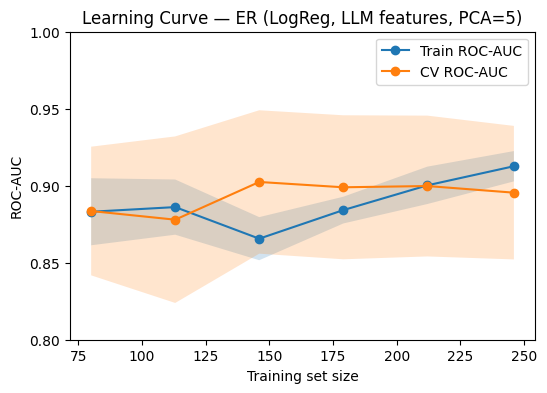

In [27]:
#plot learningcurve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold

pipe_lr = models_llm_pca["LogReg"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

n_max = min(len(train_idx) for train_idx, _ in cv.split(X_llm_plot, y))

min_required = int(np.ceil(N_COMPONENTS / (1 - 1/cv.n_splits)))
start = max(min_required, 80)
stop = n_max 

if start >= stop:
    start = max(10, stop - 1)

train_sizes_abs = np.linspace(start, stop, 6, dtype=int)

train_sizes, train_scores, val_scores = learning_curve(
    pipe_lr,
    X_llm_plot,
    y,
    cv=cv,
    scoring="roc_auc",
    train_sizes=train_sizes_abs,
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1, ddof=1)
val_std = val_scores.std(axis=1, ddof=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, marker="o", label="Train ROC-AUC")
plt.plot(train_sizes, val_mean, marker="o", label="CV ROC-AUC")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
plt.xlabel("Training set size")
plt.ylabel("ROC-AUC")
plt.title(f"Learning Curve — ER (LogReg, LLM features, PCA={N_COMPONENTS})")
plt.legend()

plt.ylim(0.8, 1.0)
plt.yticks(np.arange(0.8, 1.01, 0.05))
plt.savefig(
    "learning curve llm_10.jpeg",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


Unlike the other Courves, Train is not at about 1 for the majority of the time. This may be due to the small feature set of 17 genes, so might be Variance due to sample size.
CV = cross variation

Majority class identifyier

In [19]:
#calculate baseline dummy
import numpy as np
import pandas as pd

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    recall_score
)

X = X_llm_plot
y = y
target_name = "er"

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)

df_dummy_llm = pd.DataFrame([{
    "target": target_name,
    "model": "MajorityDummy",
    "roc_auc": np.nan,              # not defined for constant predictions
    "balanced_acc": balanced_accuracy_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "avg_precision": np.nan,         # not defined
    "accuracy": accuracy_score(y_test, y_pred),
    "recall_0": recall_score(y_test, y_pred, pos_label=0, zero_division=0),
    "recall_1": recall_score(y_test, y_pred, pos_label=1, zero_division=0),
    "N_test": int(len(y_test)),
    "pos_rate_test": float(y_test.mean())
}])

df_dummy_llm.round(3)


,target,model,roc_auc,balanced_acc,f1,avg_precision,accuracy,recall_0,recall_1,N_test,pos_rate_test
0,er,MajorityDummy,NaN,0.5,0.922,NaN,0.855,0.0,1.0,62,0.855


General majority = allways looks for most common feature. 85% ER+ = acc with 85% as expected! Obv revall 1.0 = if every pat is labeled ER+ = all will be identified! Balaced Acc = Recall 1 + Recall 2 /2 => with 0.5 its a coinflip! F1 might be good, but only uses positive class - missleading by the current imbalance!


#### ***llm full***

In [20]:
#get data
import numpy as np
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
RESULTS_DIR = PROJECT_ROOT / "results"
DATA_DIR = PROJECT_ROOT / "data"

df_gene = pd.read_csv(RESULTS_DIR / "mammacarcinoma_gex_llmaltered.csv")

df_pat = pd.read_csv(DATA_DIR / "mammacarcinoma_pat.csv")

df = df_gene.merge(df_pat[["patient_id", "er"]], on="patient_id", how="inner").dropna(subset=["er"])
df["er"] = df["er"].astype(int)

feature_cols = [c for c in df.columns if c not in ["patient_id", "er"]]
X_raw = df[feature_cols].to_numpy()
y = df["er"].to_numpy()

print("X_raw shape:", X_raw.shape, "| n_features:", len(feature_cols))
print("Pos rate:", y.mean())
print("Features:", feature_cols)


X_raw shape: (308, 12) | n_features: 12
Pos rate: 0.8506493506493507
Features: ['ESR1', 'PGR', 'GATA3', 'TFF1', 'CCND1', 'NRIP1', 'KRT18', 'AR', 'BCL2', 'NAT1', 'MAPT', 'BAG1']


In [21]:
#train models
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

RANDOM_STATE = 42

pre_raw = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

models_raw = {
    "LogReg": Pipeline([
        ("pre", pre_raw),
        ("model", LogisticRegression(
            max_iter=5000, class_weight="balanced", random_state=RANDOM_STATE
        ))
    ]),
    "RF": Pipeline([
        ("pre", pre_raw),
        ("model", RandomForestClassifier(
            n_estimators=500, class_weight="balanced_subsample",
            random_state=RANDOM_STATE, n_jobs=-1
        ))
    ]),
    "kNN": Pipeline([
        ("pre", pre_raw),
        ("model", KNeighborsClassifier(n_neighbors=11, weights="distance"))
    ]),
}


In [32]:
#get metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    f1_score,
    average_precision_score,
    brier_score_loss
)

X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

rows = []
for name, pipe in models_raw.items():
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    rows.append({
        "model": name,
        "roc_auc": roc_auc_score(y_test, y_proba),
        "avg_precision": average_precision_score(y_test, y_proba),
        "balanced_acc": balanced_accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "brier": brier_score_loss(y_test, y_proba),
    })

df_raw_holdout = (
    pd.DataFrame(rows)
    .sort_values("roc_auc", ascending=False)
)

df_raw_holdout.round(4)


,model,roc_auc,avg_precision,balanced_acc,f1,brier
1,RF,0.9790,0.9966,0.7778,0.9636,0.0574
0,LogReg,0.9602,0.9935,0.9528,0.9505,0.0776
2,kNN,0.9539,0.9922,0.7222,0.9550,0.0650


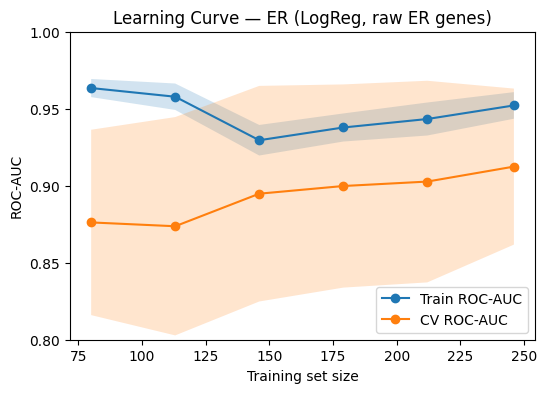

In [23]:
##plot learningcurve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold

# eindeutig:
X_er_raw = X_raw
y_er = y
pipe_lr_er_raw = models_raw["LogReg"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

n_max = min(len(train_idx) for train_idx, _ in cv.split(X_er_raw, y_er))

start = 80
stop = n_max
if start >= stop:
    start = max(10, stop - 1)

train_sizes_abs = np.linspace(start, stop, 6, dtype=int)

train_sizes, train_scores, val_scores = learning_curve(
    pipe_lr_er_raw,
    X_er_raw,
    y_er,
    cv=cv,
    scoring="roc_auc",
    train_sizes=train_sizes_abs,
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)
train_std  = train_scores.std(axis=1, ddof=1)
val_std    = val_scores.std(axis=1, ddof=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, marker="o", label="Train ROC-AUC")
plt.plot(train_sizes, val_mean, marker="o", label="CV ROC-AUC")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
plt.xlabel("Training set size")
plt.ylabel("ROC-AUC")
plt.title("Learning Curve — ER (LogReg, raw ER genes)")
plt.legend()
plt.ylim(0.8, 1.0)
plt.yticks(np.arange(0.8, 1.01, 0.05))
plt.savefig("learning curve llm_full.jpeg", dpi=300, bbox_inches="tight")
plt.show()


#### ***Creating AUC Layout***

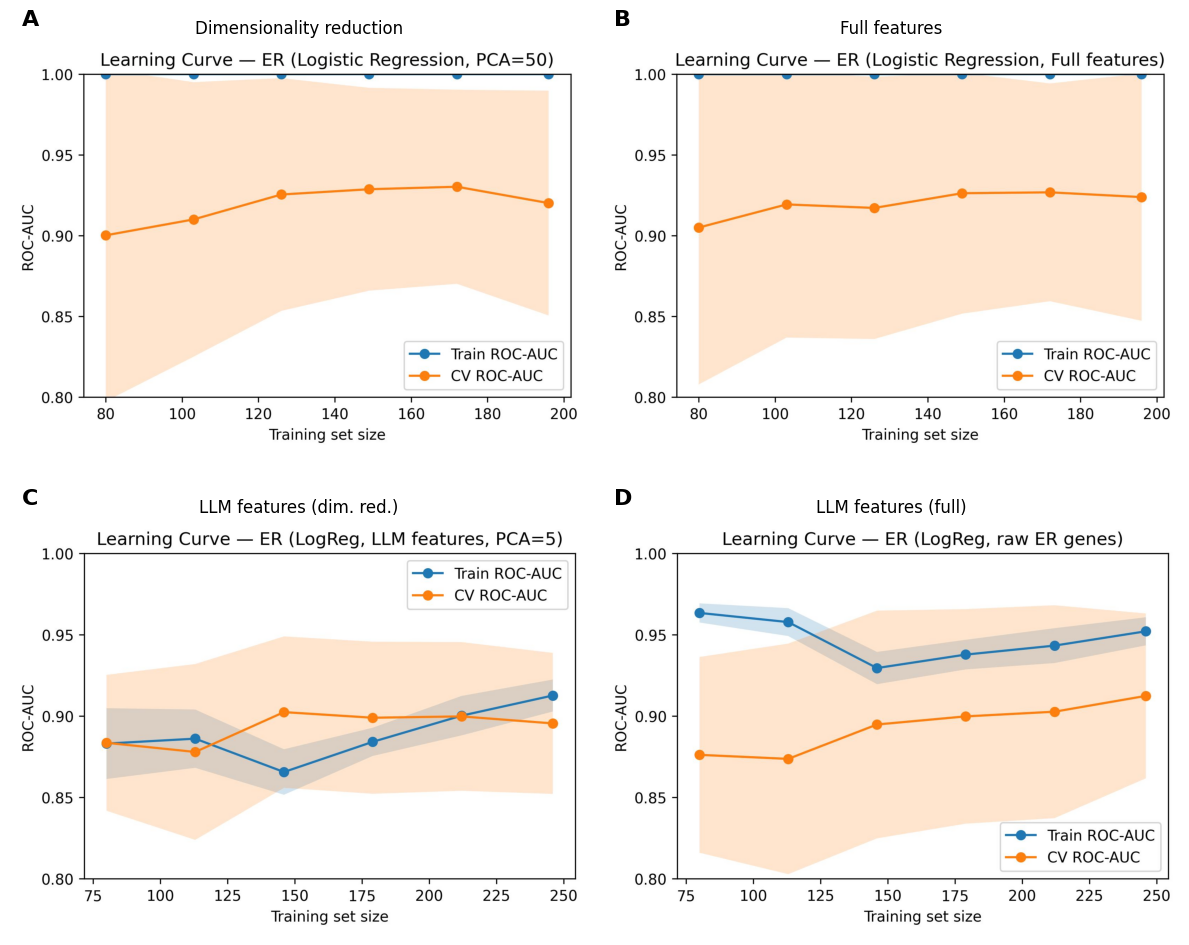

Gespeichert als: C:\PAML\PAML Project\results\learning_curve_2x2.jpg


In [29]:
#create layout for report
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

base = Path(r"C:\PAML\PAML Project\results")

files = [
    base / "learning curve dimred",
    base / "learning curve full",
    base / "learning curve llm",
    base / "learning curve llm_full",
]

titles = [
    "Dimensionality reduction",
    "Full features",
    "LLM features (dim. red.)",
    "LLM features (full)"
]

panel_labels = ["A", "B", "C", "D"]

images = []
for f in files:
    matches = list(f.parent.glob(f.name + ".*"))
    if len(matches) == 0:
        raise FileNotFoundError(f"Keine Datei gefunden für: {f}")
    images.append(Image.open(matches[0]))

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, img, title, label in zip(axes, images, titles, panel_labels):
    ax.imshow(img)
    ax.set_title(title, fontsize=12)
    ax.axis("off")

    ax.text(
        0.02, 1.08, label,
        transform=ax.transAxes,
        fontsize=16,
        fontweight="bold",
        va="top",
        ha="left"
    )

plt.tight_layout()
out = base / "learning_curve_2x2.jpg"
plt.savefig(out, dpi=300, bbox_inches="tight")
plt.show()

print("Gespeichert als:", out)
